In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from scipy import optimize
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data = sio.loadmat('data/regularized_logistic_regression.mat')
x = data['X']
y = data['y']
xval = data['Xval']
yval = data['yval']
xtest = data['Xtest']
ytest = data['ytest']

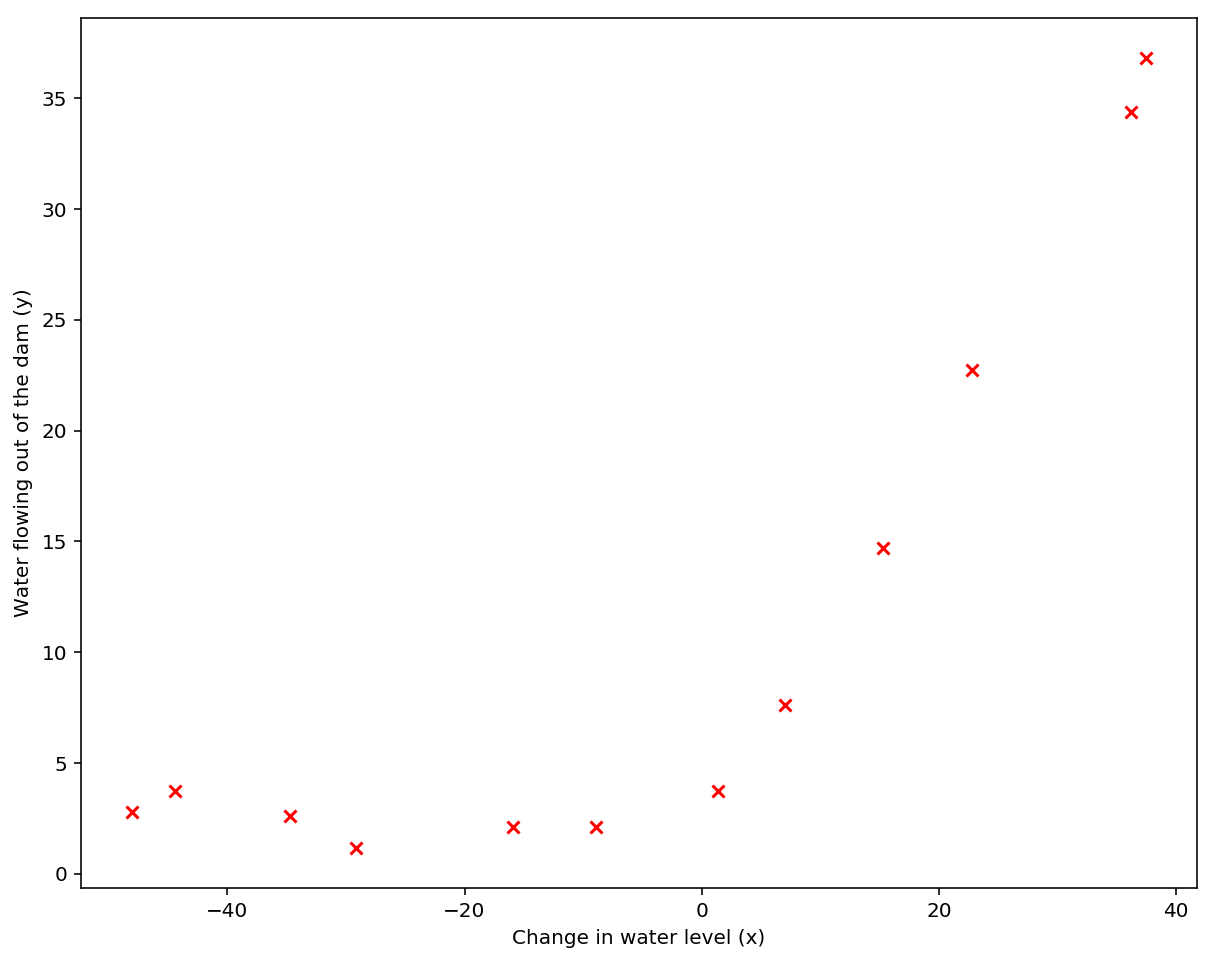

In [3]:
#visualize data
fig = plt.figure(figsize=(10,8))
plt.scatter(x,y,marker='x',color='r')
_=plt.xlabel('Change in water level (x)')
_=plt.ylabel('Water flowing out of the dam (y)')

In [4]:
#build polygon features
def poly_features(x,p):
    X = np.ones((x.shape[0],1))
    for i in range(1,p+1):
        X = np.c_[X,x**i]
    return X

In [5]:
#feature normalization
def normalize_features(X):
    x_mean = X[...,1:].mean(axis=0)
    x_std = X[...,1:].std(axis=0)
    x_normalized = (X[...,1:]-x_mean)/x_std
    x_normalized = np.c_[X[...,:1],x_normalized]
    return (x_normalized,np.r_[1,x_mean],np.r_[0,x_std])

In [6]:
#compute cost and gradients
def cost(theta,*args):
    X,y,lambd = args
    theta = np.reshape(theta,(X.shape[1],1))
    m=X.shape[0]
    J=1/(2*m)*np.sum((np.dot(X,theta)-y)**2) + lambd/(2*m)*np.sum(theta[1:]**2)
    return J

def grad(theta,*args):
    X,y,lambd = args
    m = X.shape[0]
    theta = np.reshape(theta,(X.shape[1],1))
    theta_dummy = np.copy(theta)
    theta_dummy[0,0]=0 
    grad = 1/m * np.dot(np.transpose(X),np.dot(X,theta)-y) + lambd/m *theta_dummy
    return grad.ravel()

In [7]:
#gradient descent
#num_iters=400
#J_history = np.zeros((num_iters,1))
def gradientDescent(X,y,theta,alpha,lambd,num_iters=400):
    m=X.shape[0]
    theta = np.reshape(theta,(X.shape[1],1))
    theta_dummy = np.copy(theta)
    theta_dummy[0,0]=0
    for i in range(num_iters):
        gradient = 1/m * np.dot(np.transpose(X),np.dot(X,theta)-y) + lambd/m * theta_dummy
        theta = theta - alpha*gradient
        #global J_history
        #J_history[i,0] = computeCost(X,y,theta)
    return theta.ravel()

In [8]:
def fit(x,y,p,lambd):
    X = poly_features(x,p)
    X_normalized, X_mean, X_std = normalize_features(X)
    initial_theta = np.zeros((np.shape(X)[1]))
    res = optimize.minimize(fun=cost, x0=initial_theta, args=(X_normalized,y,lambd), jac=grad, method=None, options={'maxiter':400, 'disp':False})
    theta = res['x']
    return (theta, X_mean, X_std)

In [9]:
def fit_gd(x,y,p,alpha=0.1,lambd=0,iters=400):
    X = poly_features(x,p)
    X_normalized, X_mean, X_std = normalize_features(X)
    initial_theta = np.zeros((np.shape(X)[1]))
    theta = gradientDescent(X_normalized,y,initial_theta,alpha,lambd,iters)
    return (theta, X_mean, X_std)

In [10]:
#compute y values for visualization of polynomial fit given theta and x
def pred_y(x,theta,mu,std):
    p = len(theta)-1
    x = np.reshape(x,(len(x),1))
    X = poly_features(x,p)
    Xtemp = (X[...,1:] - mu[1:])/std[1:]
    X = np.c_[X[...,:1],Xtemp]
    theta = np.reshape(theta,(X.shape[1],1))
    y = np.dot(X,theta)
    return y.ravel()

In [11]:
def visualize(theta,mu,std):
    fig = plt.figure(figsize=(10,8))
    plt.scatter(x,y,marker='x',color='r')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    xrange = np.linspace(x.min()-15,x.max()+15,100)
    yrange = pred_y(xrange,theta,mu,std)
    _=plt.plot(xrange,yrange)
    _=plt.ylim([-5,40])

In [12]:
#plot learning curves
def plot_learning_curves(p,lambd):
    train_err = np.zeros((x.shape[0],))
    val_err = np.zeros((x.shape[0],))
    for i in range(len(x)):
        xtemp = x[0:i+1,...]
        ytemp = y[0:i+1,...]
        theta,mu,sigma = fit(xtemp,ytemp,p,lambd)
        y_pred_train = pred_y(xtemp,theta,mu,sigma)
        train_err[i] = 1/(2*(i+1))*np.sum((y_pred_train-ytemp.ravel())**2)
        y_pred_val = pred_y(xval,theta,mu,sigma)
        val_err[i] = 1/(2*xval.shape[0])*np.sum((y_pred_val-yval.ravel())**2)

    plt.plot(train_err)
    plt.plot(val_err,'g')
    plt.ylim([0,150]) 
    plt.xlabel('number of examples')
    _=plt.ylabel('error')

In [13]:
#plot learning curves
def plot_learning_curves_gd(p,alpha=0.1,lambd=0,iters=400):
    train_err = np.zeros((x.shape[0],))
    val_err = np.zeros((x.shape[0],))
    for i in range(len(x)):
        xtemp = x[0:i+1,...]
        ytemp = y[0:i+1,...]
        theta,mu,sigma = fit_gd(xtemp,ytemp,p,alpha,lambd,iters)
        y_pred_train = pred_y(xtemp,theta,mu,sigma)
        train_err[i] = 1/(2*(i+1))*np.sum((y_pred_train-ytemp.ravel())**2)
        y_pred_val = pred_y(xval,theta,mu,sigma)
        val_err[i] = 1/(2*xval.shape[0])*np.sum((y_pred_val-yval.ravel())**2)

    plt.plot(train_err)
    plt.plot(val_err,'g')
    plt.ylim([0,150]) 
    plt.xlabel('number of examples')
    _=plt.ylabel('error')

In [14]:
#check cost and gradient functions
X1 = poly_features(x,1)
initial_theta = np.ones(X1.shape[1])
lambd=1
print(cost(initial_theta,X1,y,lambd))
print(grad(initial_theta,X1,y,lambd))

303.9931922202643
[-15.30301567 598.25074417]


In [15]:
# fit 1st degree polynomial
theta1, X1_mean, X1_std = fit(x,y,1,0)

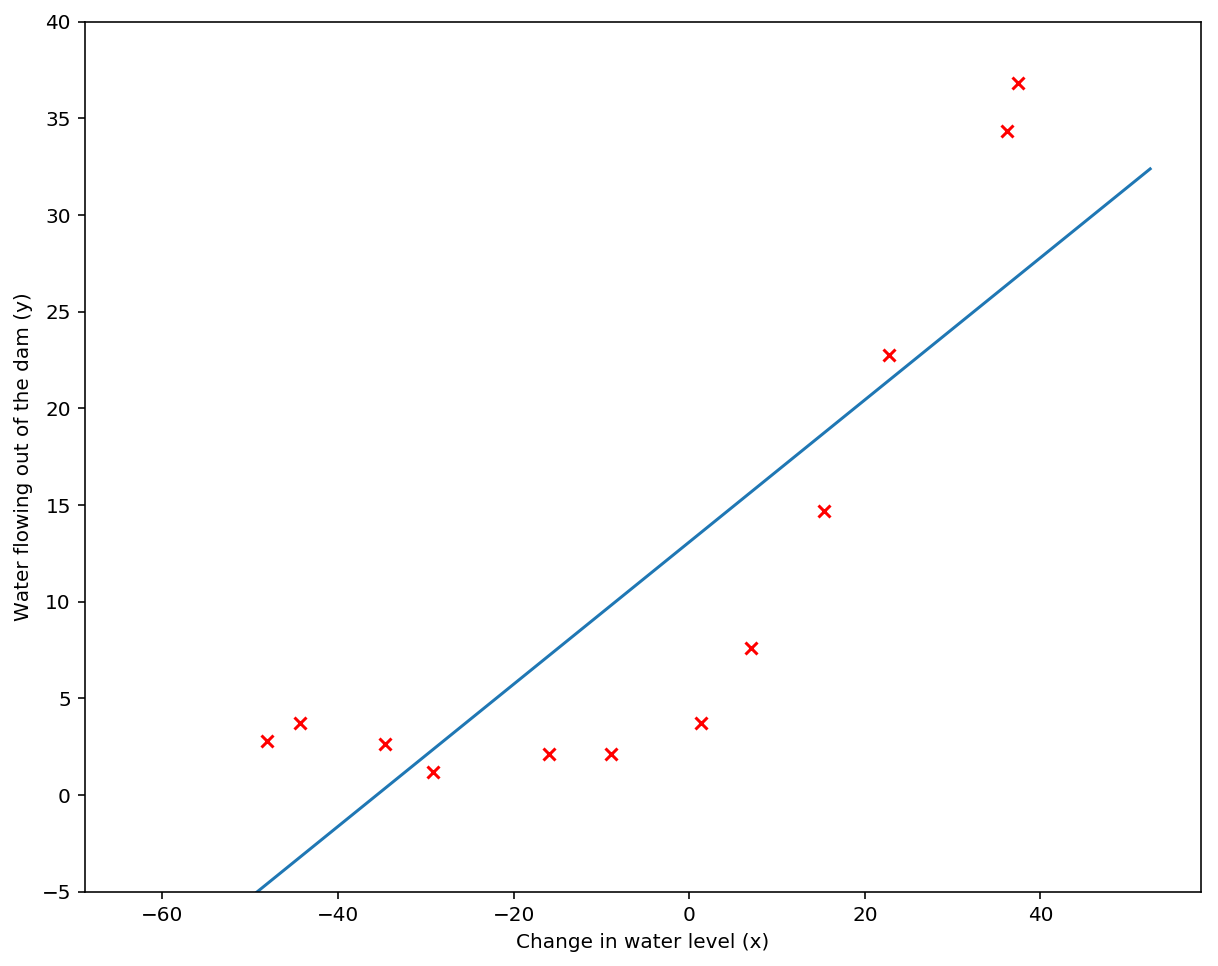

In [16]:
visualize(theta1,X1_mean,X1_std)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


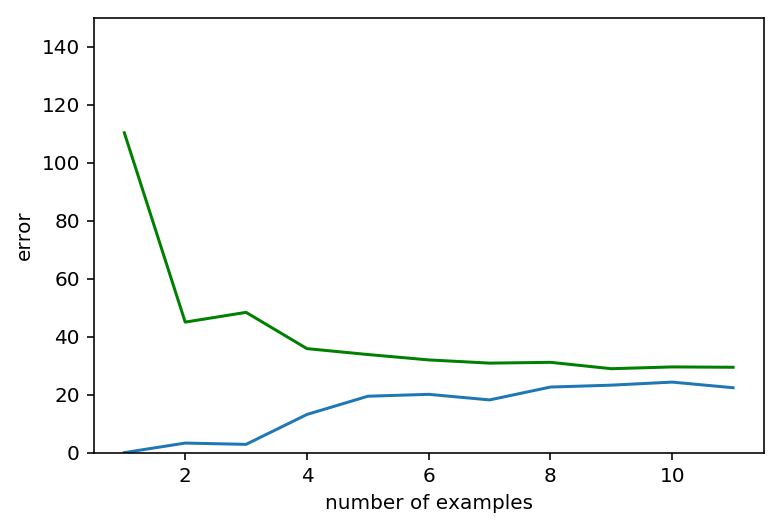

In [17]:
plot_learning_curves(1,0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


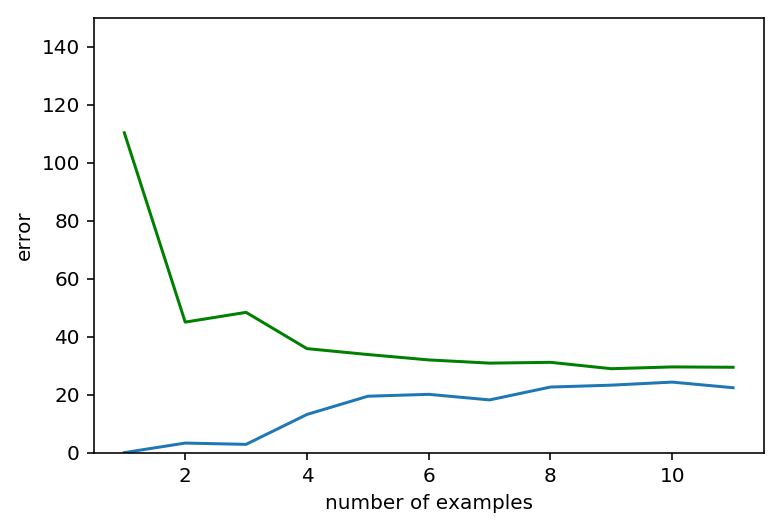

In [18]:
plot_learning_curves_gd(1,0.1,0,500)

In [19]:
#fit 8th order polynomial
theta8,X8_mean,X8_std = fit(x,y,8,0)

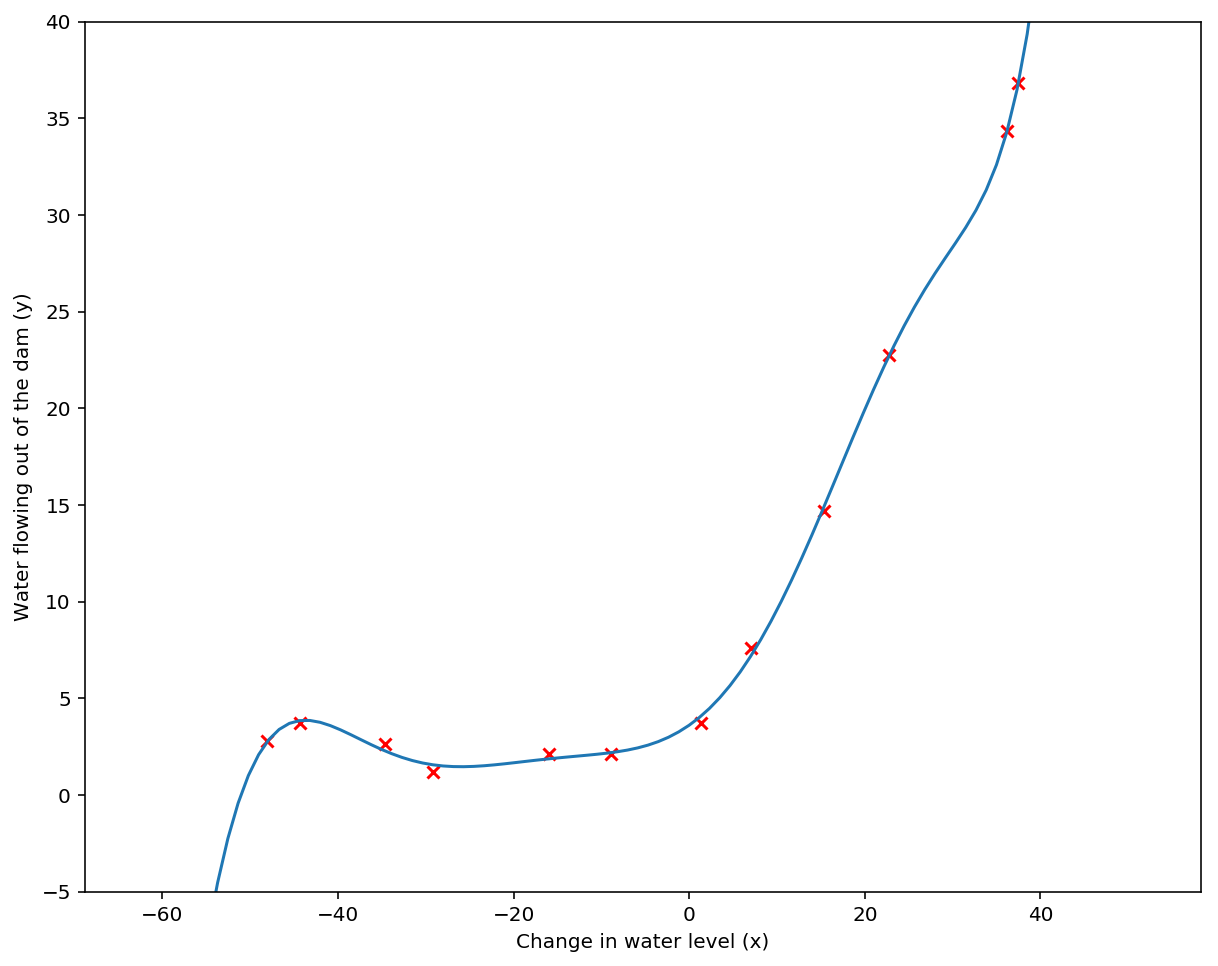

In [20]:
#scipy optimize 8th order fit
visualize(theta8,X8_mean,X8_std)

In [21]:
theta8_gd, X8_mean_gd, X8_std_gd = fit_gd(x,y,8,0.1,0,5000)

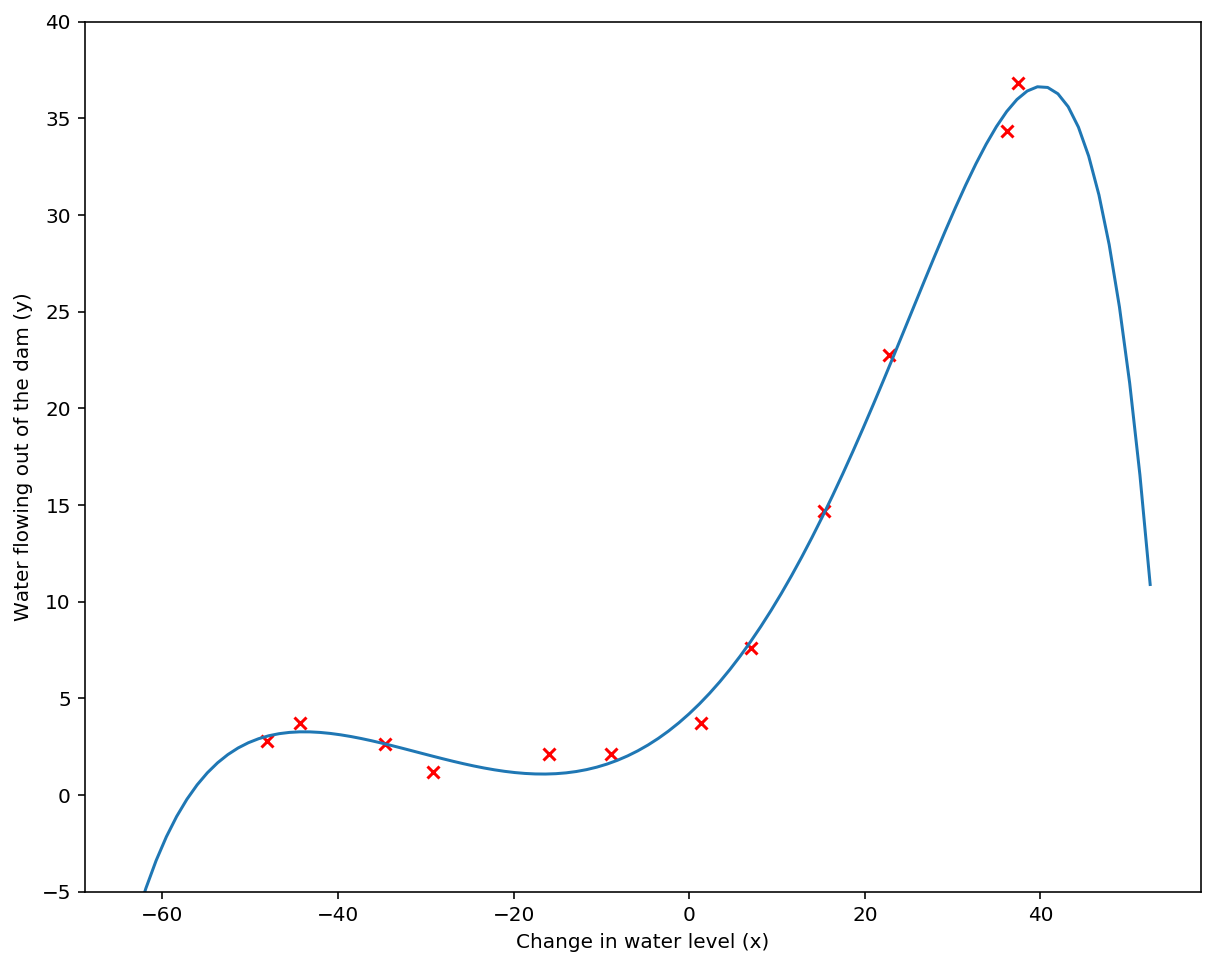

In [22]:
#gradient descent 8th order fit
visualize(theta8_gd,X8_mean_gd,X8_std_gd)

In [23]:
X = poly_features(x,8)
X8_normalized = normalize_features(X)
X8_normalized, X8_mean, X8_std = normalize_features(X)
theta8_ne = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(X8_normalized),X8_normalized)),np.transpose(X8_normalized)),y)

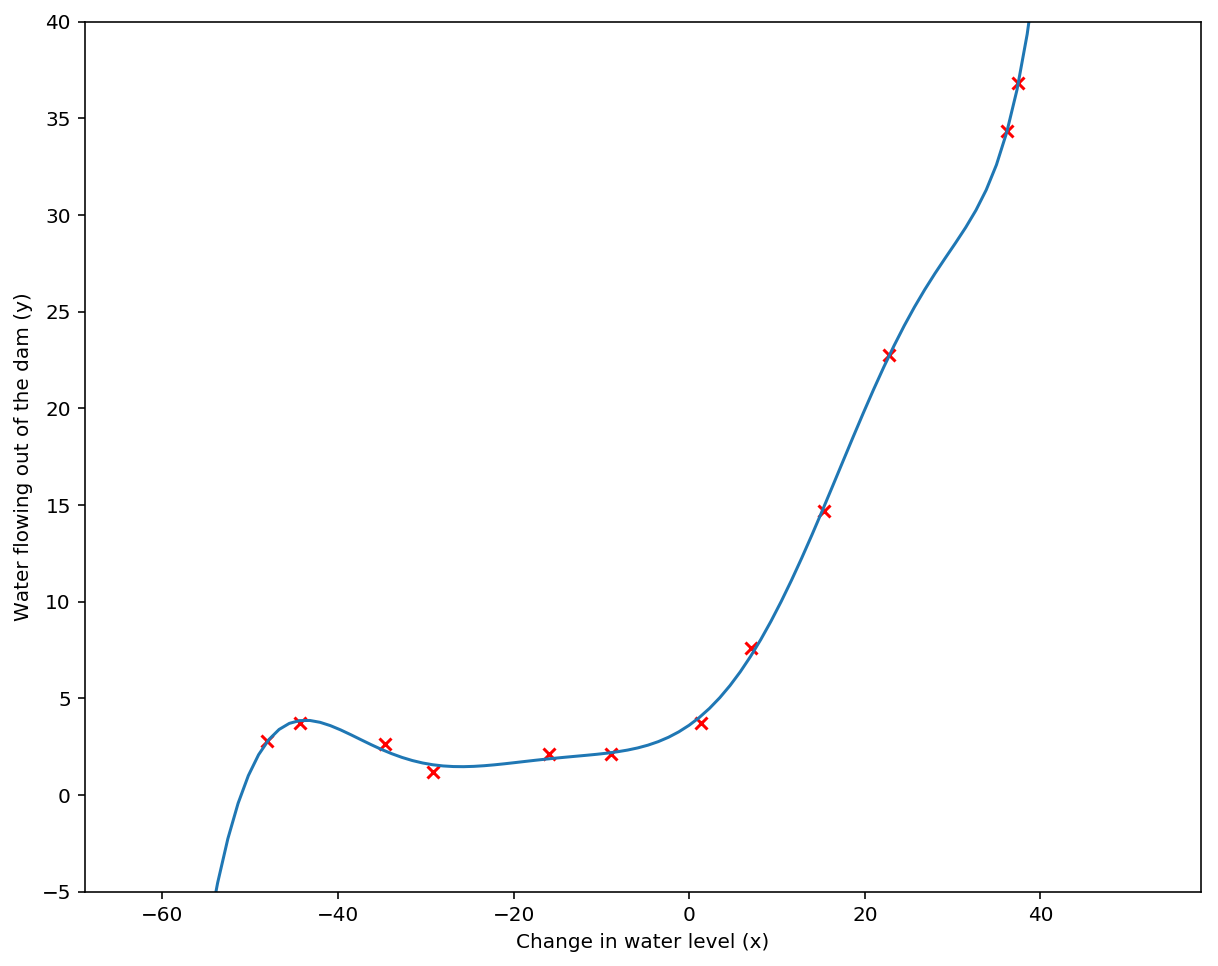

In [24]:
#normal equation 8th order fit
visualize(theta8_ne,X8_mean,X8_std)

In [25]:
theta8_ang = np.array([11.215,11.369,14.946,11.386,-13.756,-16.5,9.16,5.655,-4.75])

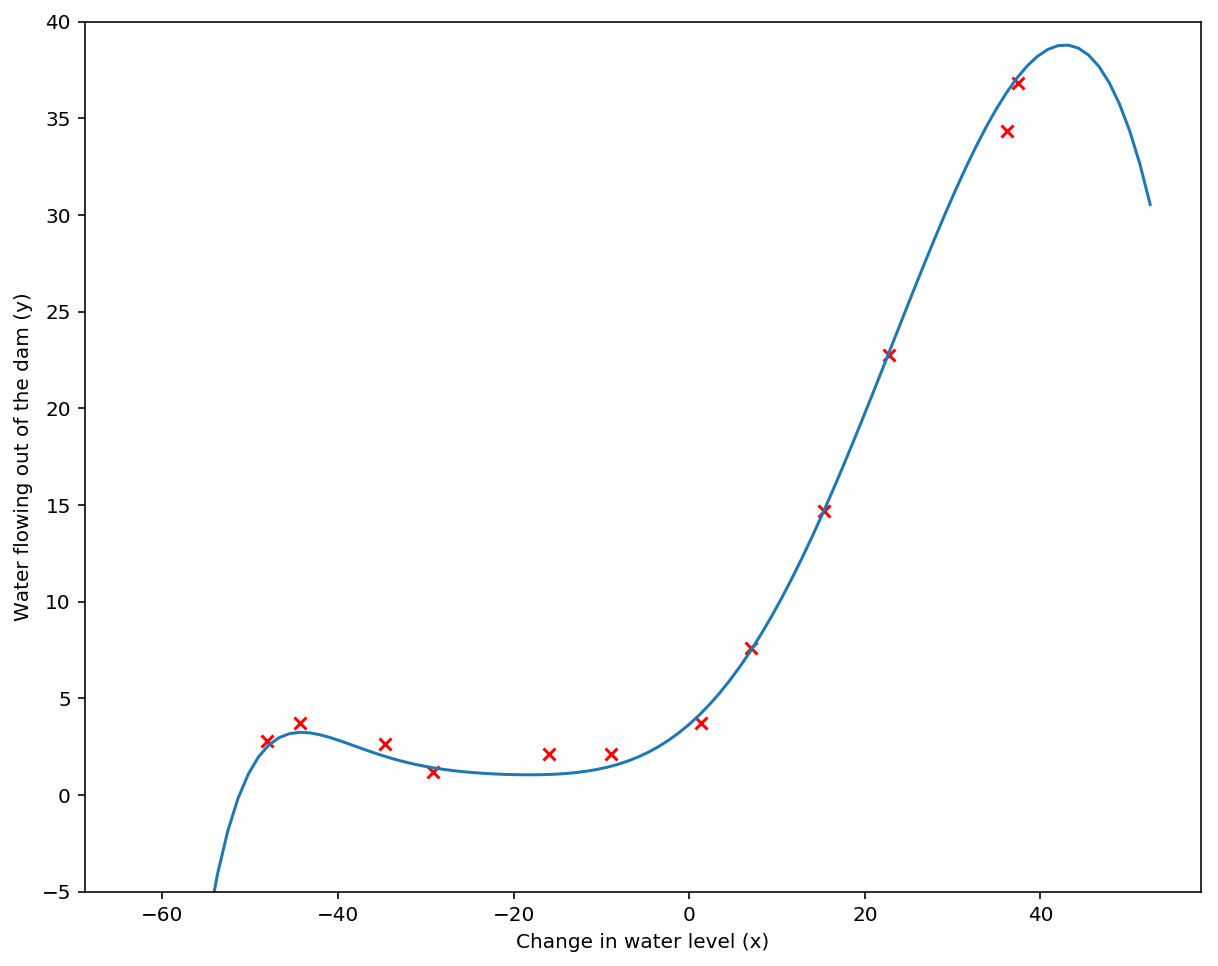

In [26]:
#andrew ng 8th order fit
visualize(theta8_ang,X8_mean,X8_std)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


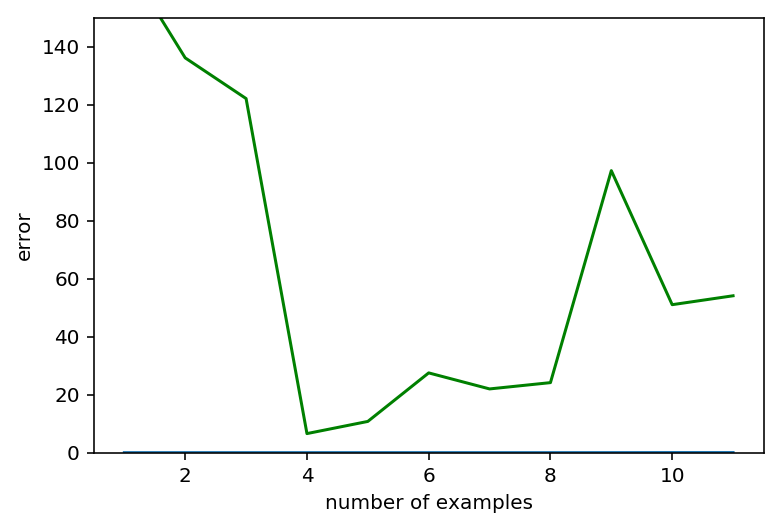

In [27]:
#plot learning curves
plot_learning_curves(8,0)

In [28]:
theta8_reg,X8_mean_reg,X8_std_reg = fit(x,y,8,1)

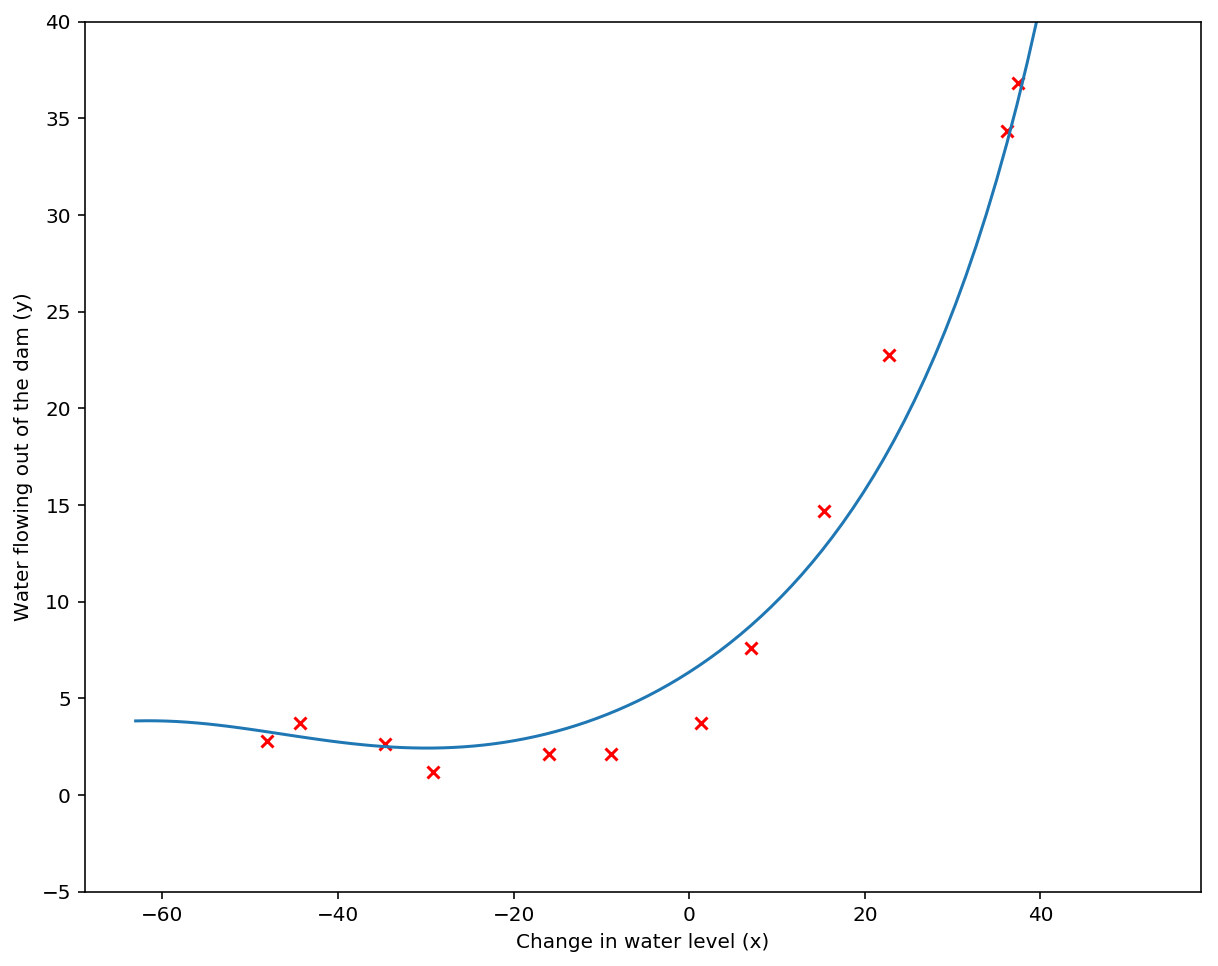

In [29]:
#regularized 8th order fit
visualize(theta8_reg,X8_mean_reg,X8_std_reg)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


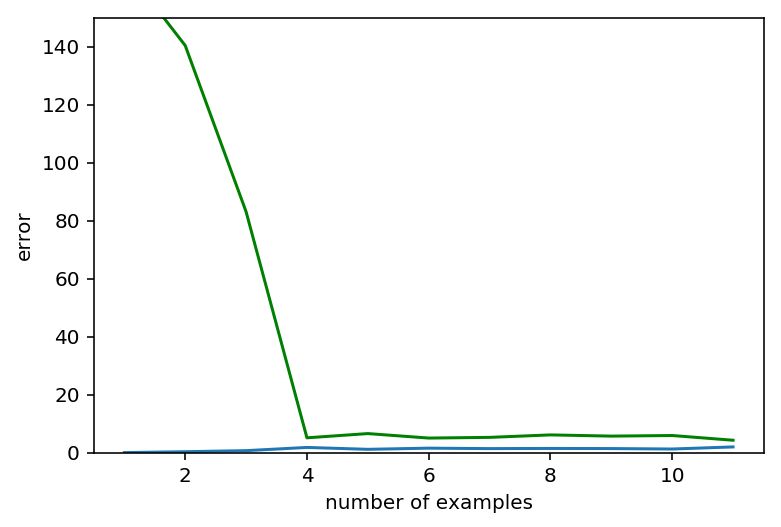

In [30]:
plot_learning_curves(8,1)

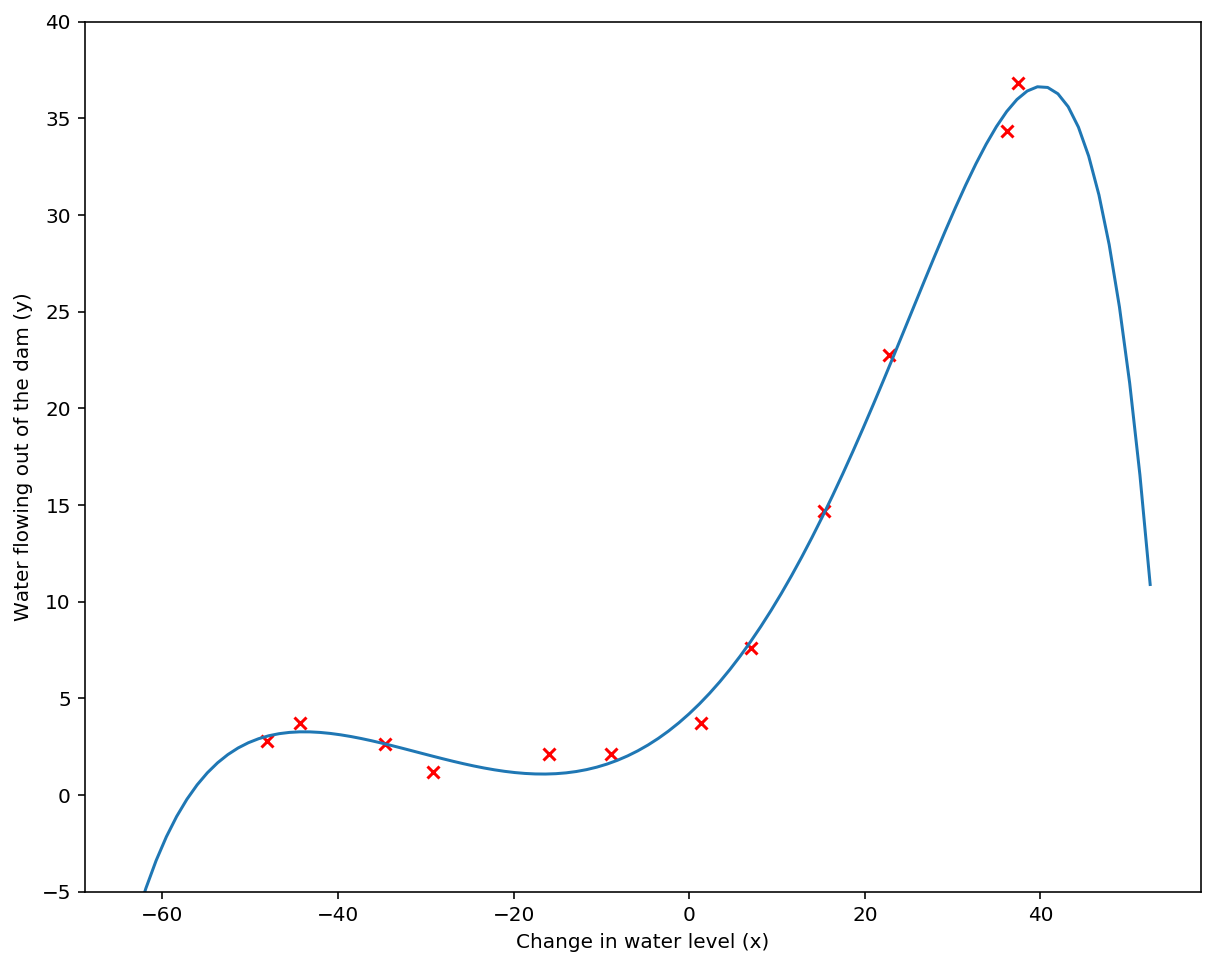

In [31]:
theta8_gd_reg, X8_mean_gd_reg, X8_std_gd_reg = fit_gd(x,y,8,0.1,100,5000)
visualize(theta8_gd_reg,X8_mean_gd_reg,X8_std_gd_reg)

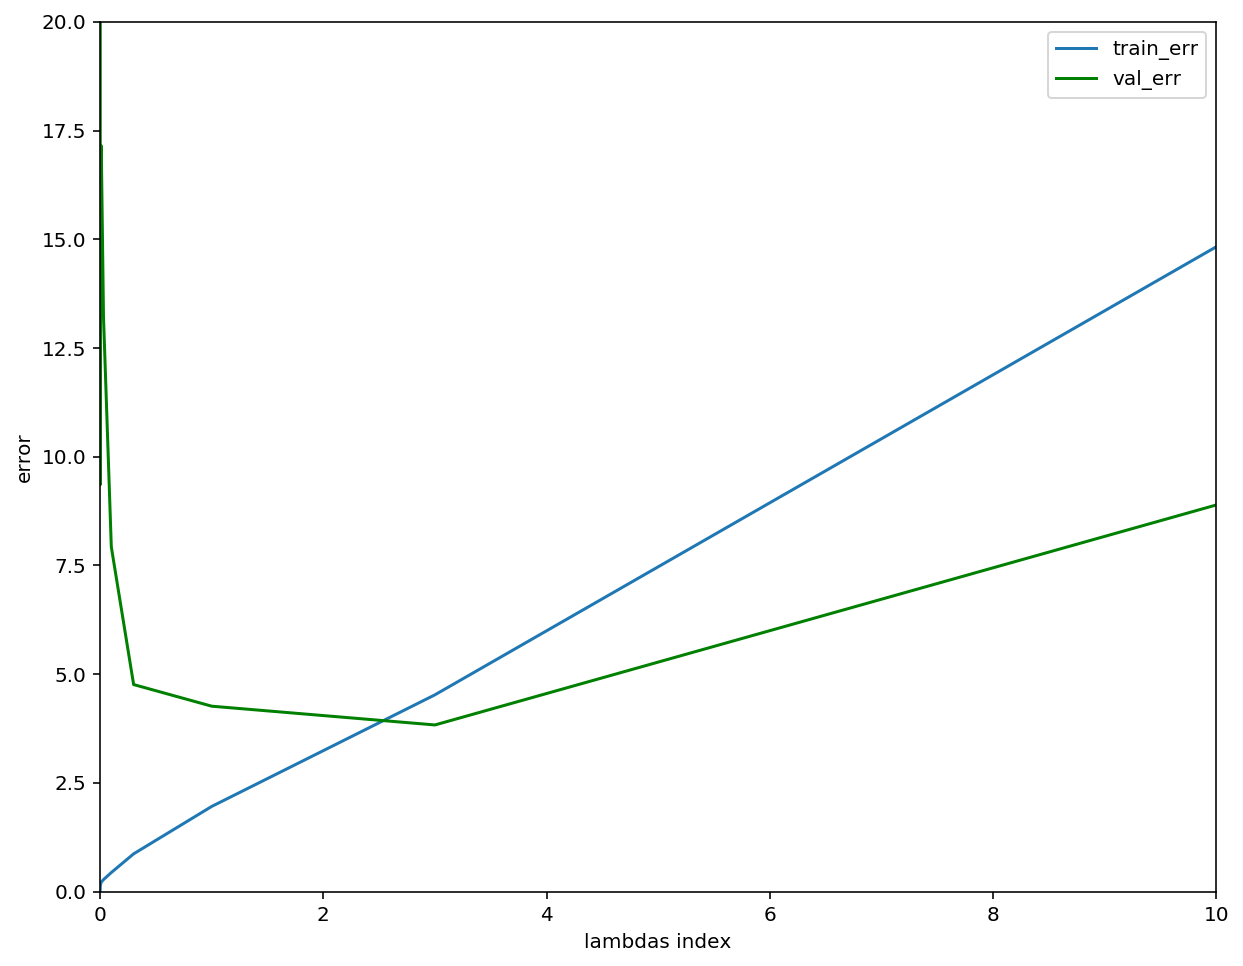

In [32]:
lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_err = np.zeros((len(lambdas),))
val_err = np.zeros((len(lambdas),))
for i,lambd in enumerate(lambdas):
    theta,mu,sigma = fit(x,y,8,lambd)
    y_pred_train = pred_y(x,theta,mu,sigma)
    m = x.shape[0]
    train_err[i] = 1/(2*x.shape[0])*np.sum((y_pred_train-y.ravel())**2)
    y_pred_val = pred_y(xval,theta,mu,sigma)
    val_err[i] = 1/(2*xval.shape[0])*np.sum((y_pred_val-yval.ravel())**2)

fig=plt.figure(figsize=(10,8))
plt.plot(lambdas,train_err,label='train_err')
plt.plot(lambdas,val_err,'g',label='val_err')
plt.xlabel('lambdas index')
_=plt.ylabel('error') 
_=plt.xlim([0,10])
_=plt.ylim([0,20])
_=plt.legend()

In [33]:
#best lambda = 3; computing test set error
theta,mu,sigma = fit(x,y,8,3)
y_pred_test = pred_y(xtest,theta,mu,sigma)
error = 1/(2*xtest.shape[0])*np.sum((y_pred_test-ytest.ravel())**2)
print(error)

3.5720266461333723
